# Evaluation against other simulators
Since we have not yet been able to perform measurements in a fully controlled environment, we have looked for additional means of evaluation our algorithm. For this, we have contacted a few companies (Remcom, Altair and EMACH Technologies) for quotes on their electromagnetic simulation suites. Unfortunately, we could only afford to evaluate one suite due to budget constraints. The results of this comparison, namely with the solvers by EMAG Technologies, is documented in this notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Simplest test case: a metallic box
The most basic scene to verify the accuracy of algorithms is a simple metallic box. Since such a box can only reflect radar waves directly (i.e. there are no reflections of higher order) it is suited well to get a first impression on the accuracy of an algorithm.

### EM.Illumina (IPO)
Our first candidate for this simulation was _EM.Illumina_. Similar to our algorithm, this solver is based on physical optics. While our algorithm uses Monte Carlo to estimate integrals, EM.Illumina relies on surface discretisation of the mesh instead. Unfortunately, this means that the algorithm has a strong dependency on the size of the object in relation to the wavelength. If you double the size of your object (or alternatively double your frequency), you have to spend roughly 16 times as much time to simulate it!

The results produced by this algorithm agree very well with our own measurements.
In the table below you can find an overview over the runtime and important parameters of the simulation.

| | |
|-|-|
|**CPU utilization**|~40% (poor)|
|**Time to finish**|37m 22s|
|**Time per step**|2.33 seconds|
|**Mesh density**|3 cells / $\lambda_0$|

In [2]:
# note that LoS contribution cannot be excluded, so we simulated the scene without
# any scatterers to get the LoS-only solution which we can then subtract from the
# full simulation.

# X  Y  Z  EMagX  EPhX  EMagY  EPhY  EMagZ  EPhZ  HMagX  HPhX  HMagY  HPhY  HMagZ  HPhZ
# pos
# 0.000000e+000 1.000000e-003 0.000000e+000
# E
# 0.000000e+000 0.000000e+000
# 0.000000e+000 0.000000e+000
# 9.016442e+002 1.117446e+000
# H
# 2.616162e+000 1.146051e+000
# 0.000000e+000 0.000000e+000
# 0.000000e+000 0.000000e+000

LoS = 9.016442e+002 * np.exp(1.117446e+000j)

In [3]:
# load the data from the near field sensors
N = 961
data = np.zeros((N, 15))
for i in range(N):
    data[i,:] = np.genfromtxt("others/em.illumina/SimpleBoxPO/Sensor_1_%d.SEN" % (i+1))

In [4]:
# note that there is a bug with near field sensors
# they need to be shifted by 0.5 meters so that they end up in the
# desired location.

data[0, 0:3]

array([0.   , 0.001, 0.   ])

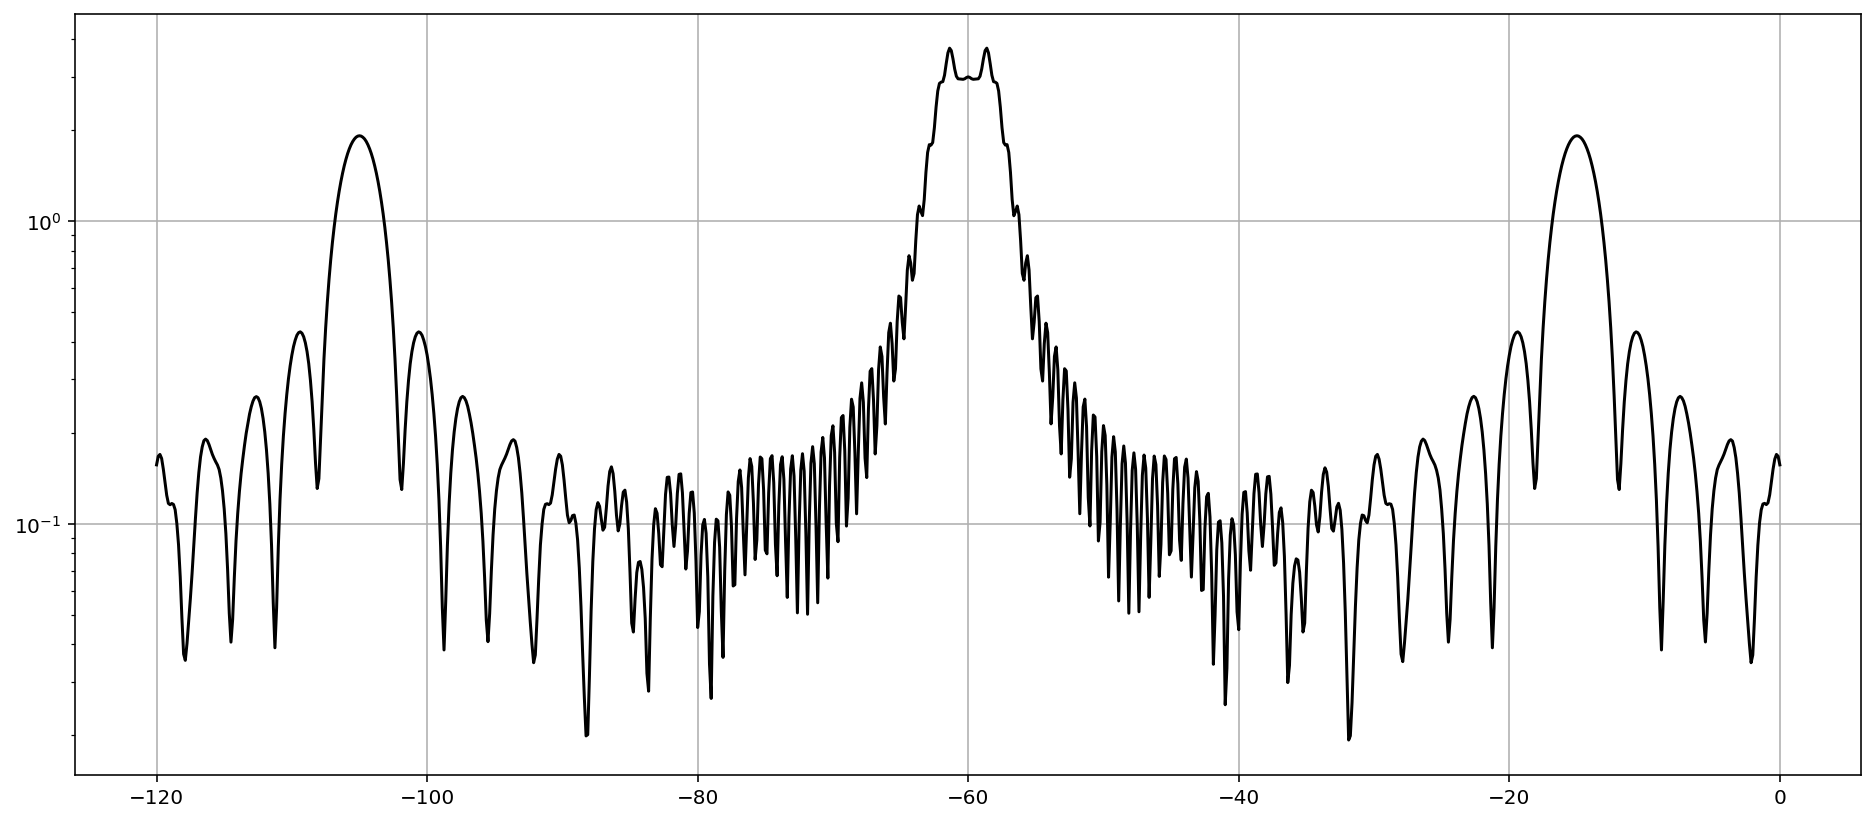

In [5]:
v = data[:,7] * np.exp(1j*data[:,8])
v -= LoS

plt.figure(figsize=(16,7))
plt.semilogy(np.linspace(-120, 0, N), np.abs(v), c="k")
plt.grid('both')
plt.show()

### EM.Terrano (SBR: GO+UTD)
Our second candidate was _EM.Terrano_, which similar to our algorithm is based on ray tracing. Unlike our algorithm, however, it uses geometrical optics and simulates diffraction through the _uniform theory of diffraction_.

Unfortunately, this solver has some numerical instabilities which cause it to sometimes miss intersections of rays with triangles or report incorrect hit points, resulting in very instable results.
As can be seen in the table below, the solver is very limited in terms of parallel execution.
It does not make use of the full potential of the hardware, resulting in a simulation that is rather slow.

| | |
|-|-|
|**CPU utilization**|~10% (very poor)|
|**Time to finish**|45m 26s|
|**Time per step**|2.84 seconds|
|**Rays per step**|40,500|

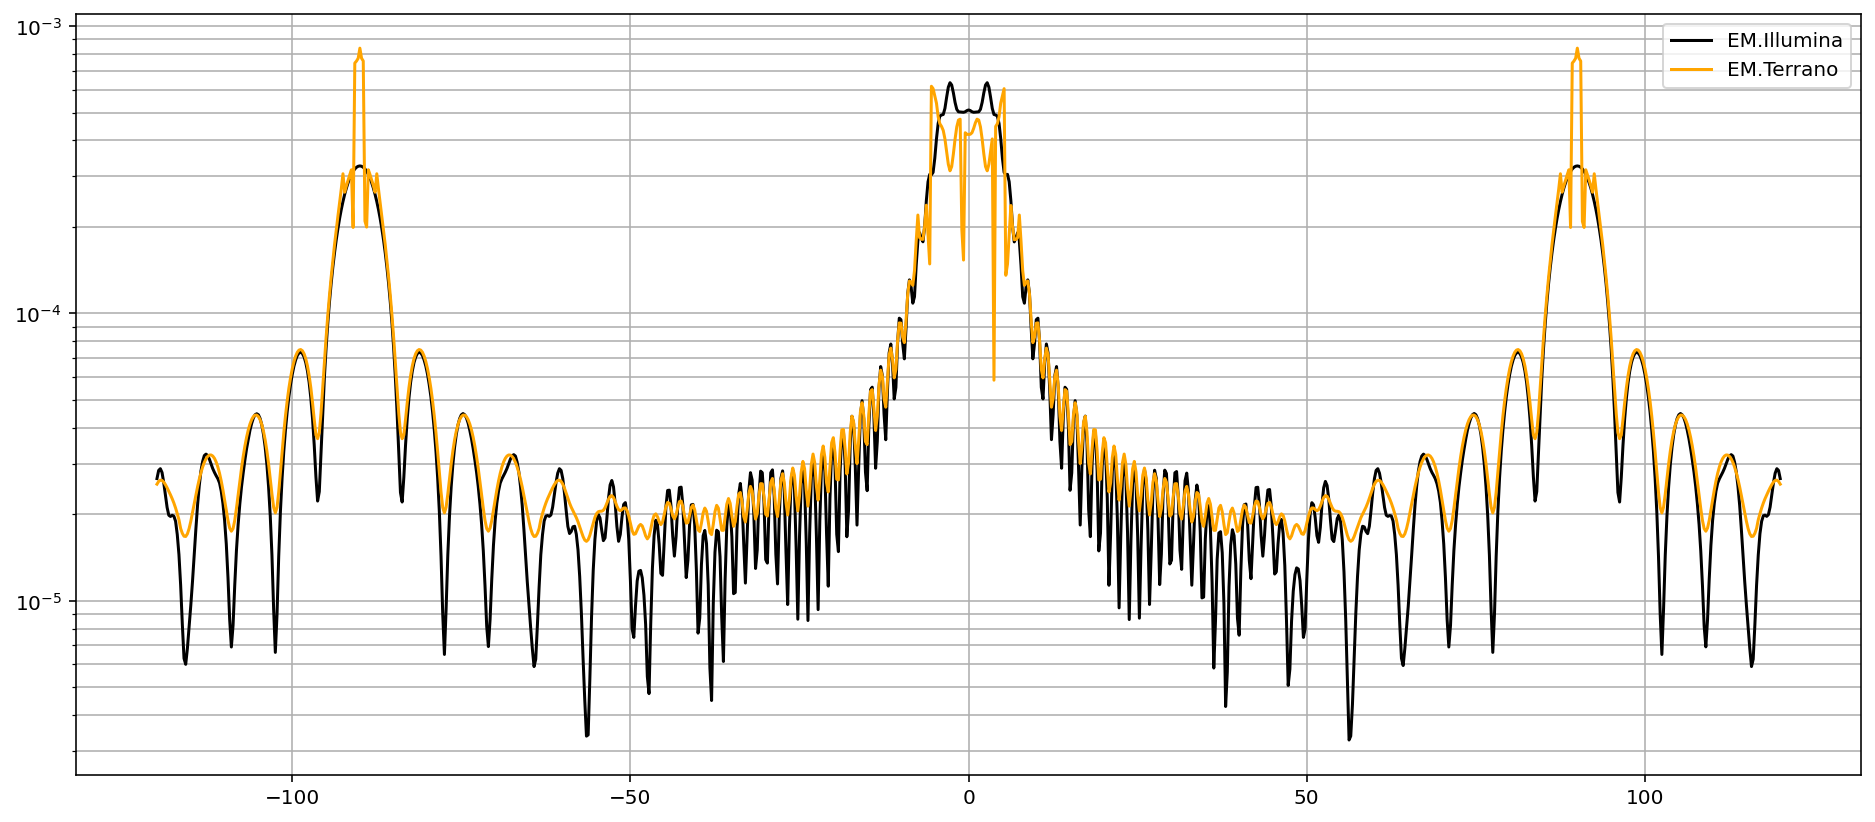

In [6]:
data = np.genfromtxt("others/em.terrano/SimpleBoxSBR/MasterFile.DAT")[1:,:]

plt.figure(figsize=(16,7))
plt.semilogy(data[:,0], np.abs(v)*1.7e-4, c="black", label="EM.Illumina")
plt.semilogy(data[:,0], 10 ** (data[:,3] / 20), c="orange", label="EM.Terrano")
plt.legend()
plt.grid(which="both")
plt.show()

## EM.Libera (MoM)
Last but not least there is _EM.Libera_, a solver based on the _method of moments_.
While this solver promises to perform even more accurate simulation of wave effects, it is unfortunately not suited for the millimeter waves that we are dealing with.

| | |
|-|-|
|**CPU utilization**|~100% (very good)|
|**Time per step**|> 30 minute|

Steps take too long, a full simulation would take at least a few years.

---
## Dihedral reflectors
After determining that only _EM.Illumina_ satisfies our requirements in the radar context, we have tested it with slightly more complex scenes: dihedral reflectors.

Unfortunately, the results we observe with this test scene deviate significantly from our measurements and our own simulations.

### Runtime and other observations
For 3 cells / $\lambda_0$:

| edge length | runtime | CPU utilization |
|------|----------|------|
|  5cm |  20m 18s | ~40% (poor) |
|  7cm |  41m 30s | ~70% (good) |
| 10cm | 188m 10s | ~90% (very good) |
| 15cm | 808m 24s | ~95% (very good) |

We have also tested different mesh resolutions:

| edge length | cells / $\lambda_0$ | runtime | observation |
|-|-|-|-|
|  5cm | 6 | 222m 52s | no noticeable improvement in quality |
| 15cm | 1 |  18m 17s | results are degraded significantly |

In [7]:
LoS = 867.3713 * np.exp(1.117446j)

In [8]:
N = 601
data = np.zeros((N, 15))
for i in range(N):
    data[i,:] = np.genfromtxt("others/em.illumina/Dihedral150/Sensor_1_%d.SEN" % (i+1))

In [9]:
# note that there is a bug with near field sensors
# they need to be shifted by 0.5 meters so that they end up in the
# desired location.

data[0, 0:3]

array([0.896, 0.015, 0.067])

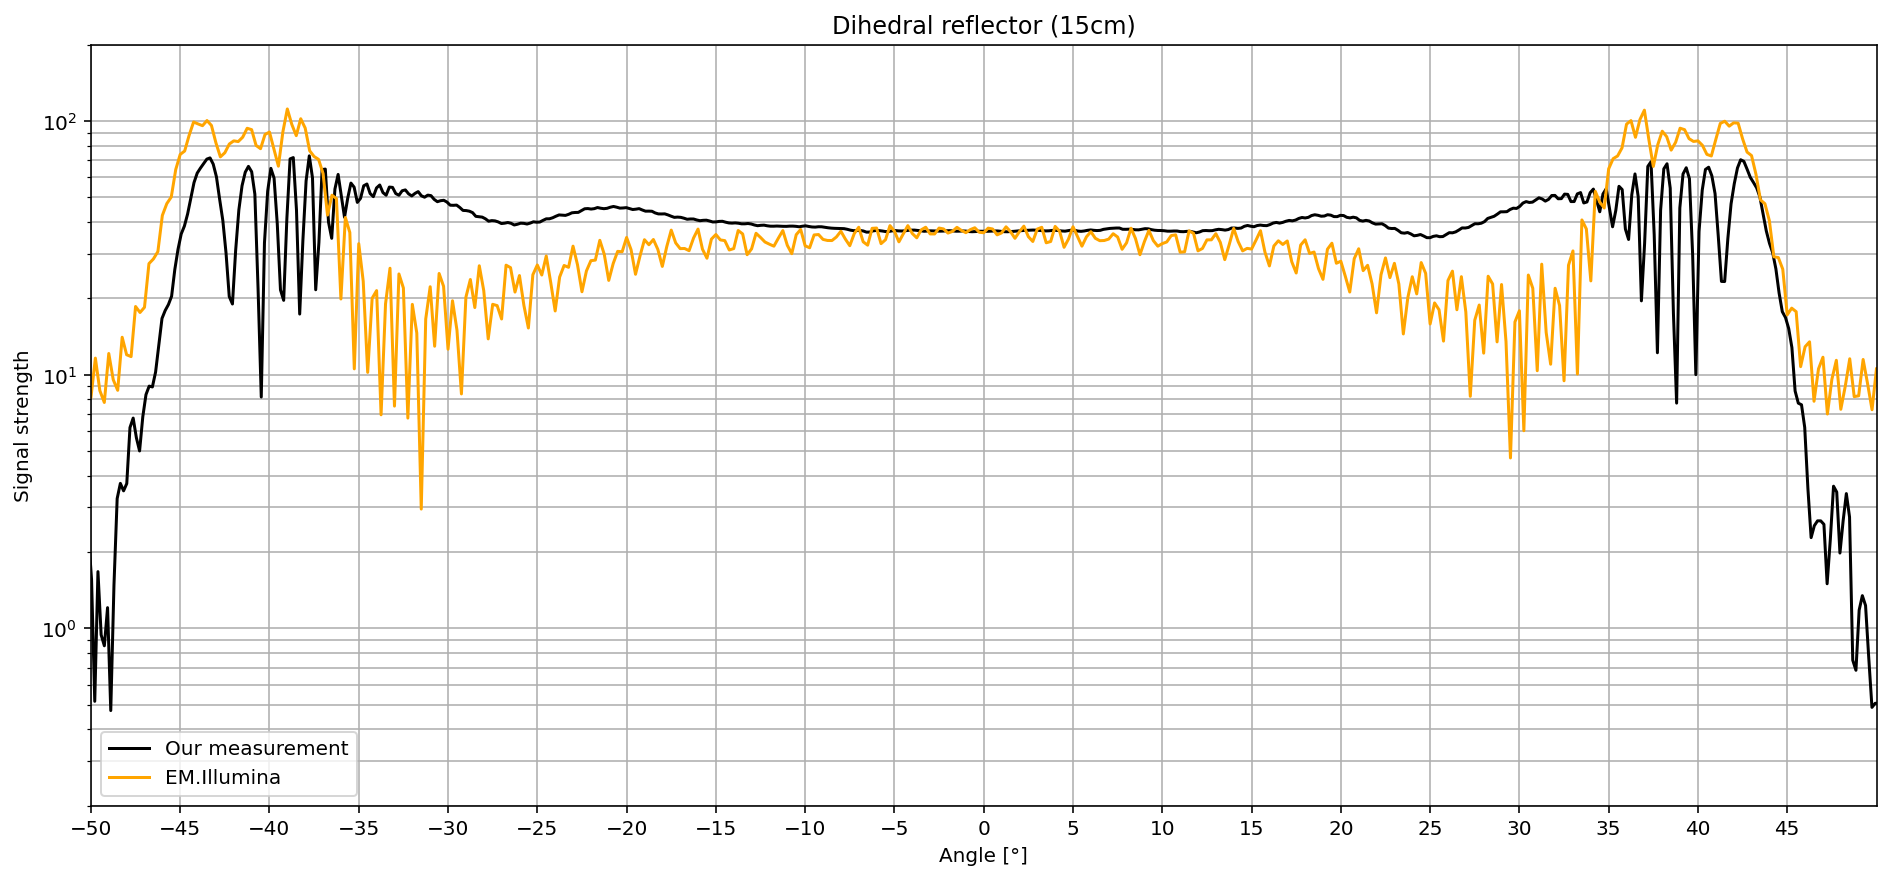

In [10]:
measurement_y = np.fromfile("measurements/dihedral-15cm", np.complex64).reshape((-1, 256))[:,20]
measurement_x = 53.8 * np.linspace(+1, -1, measurement_y.size) - 2.8

v = data[:,7] * np.exp(1j*data[:,8])
v -= LoS

plt.figure(figsize=(16,7))
plt.semilogy(measurement_x, np.abs(measurement_y), c="black", label="Our measurement")
plt.semilogy(np.linspace(+75, -75, v.size), np.abs(v) * 80, c="orange", label="EM.Illumina")
plt.grid(which="both")
plt.gca().set_xticks(np.arange(-50, +50, 5))
plt.xlim(-50, +50)
plt.ylim(2e-1, 2e+2)
plt.xlabel("Angle [°]")
plt.ylabel("Signal strength")
plt.title("Dihedral reflector (15cm)")
plt.legend()
plt.show()

## Our simulation algorithm
Our algorithm shows significantly better agreement with our measurements, while also running roughly 1,600x as fast as _EM.Illumina_ on the same hardware.

| | |
|-|-|
|**CPU utilization**|~100% (very good)|
|**Time to finish**|33s|
|**Time per step**|0.05 seconds|
|**Rays per step**|~500,000|

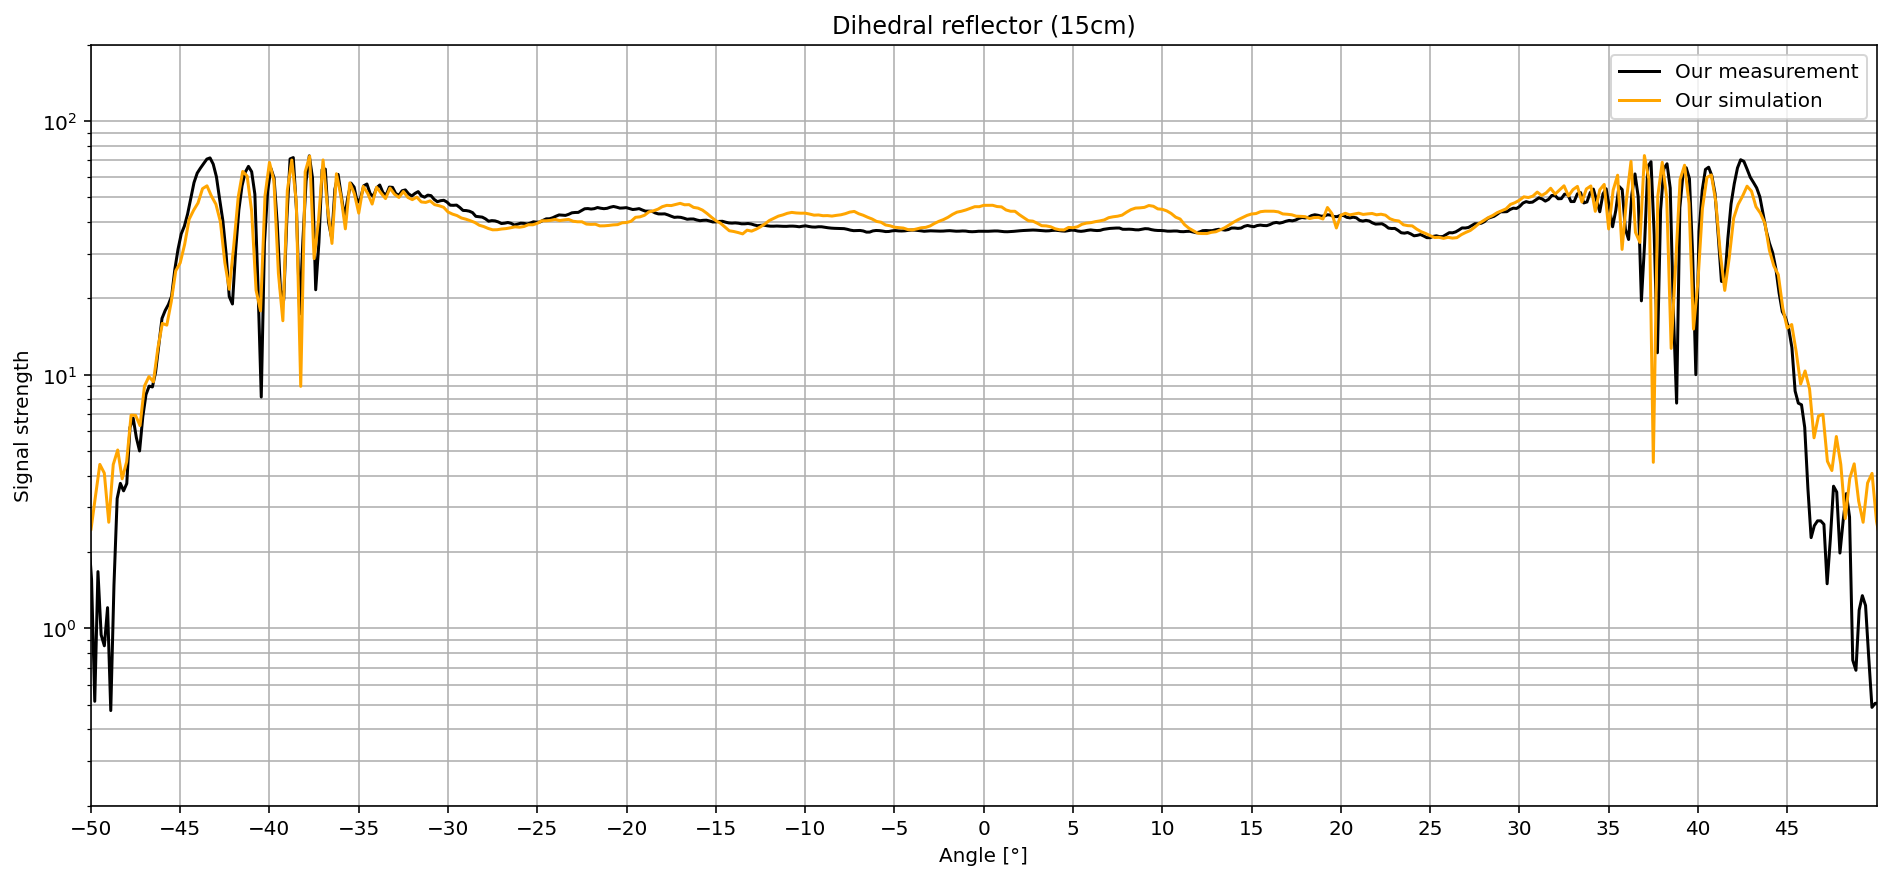

In [11]:
measurement_y = np.fromfile("measurements/dihedral-15cm", np.complex64).reshape((-1, 256))[:,20]
measurement_x = 53.8 * np.linspace(+1, -1, measurement_y.size) - 2.8

simulation_y = np.fromfile("simulation/dihedral-15cm", np.complex64).reshape((-1, 256))[:,20]
simulation_x = np.linspace(-75, +75, simulation_y.size)

plt.figure(figsize=(16,7))
plt.semilogy(measurement_x, np.abs(measurement_y), c="black", label="Our measurement")
plt.semilogy(simulation_x, np.abs(simulation_y) / 9.2, c="orange", label="Our simulation")
plt.grid(which="both")
plt.gca().set_xticks(np.arange(-50, +50, 5))
plt.xlim(-50, +50)
plt.ylim(2e-1, 2e+2)
plt.xlabel("Angle [°]")
plt.ylabel("Signal strength")
plt.title("Dihedral reflector (15cm)")
plt.legend()
plt.show()